In [30]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from pyrolite.util.plot.style import ternary_color
from pyrolite.plot import pyroplot

import cmcrameri.cm as cmc

In [5]:
def myround(x, base=5):
    return base * round(x/base)

In [6]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [7]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [8]:
def get_mag(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    mag = db['scardec_magnitude'].values[0]
    return mag

def get_date(scardec_name):
    db = combined[combined['scardec_name']==scardec_name]
    year = db['year'].values[0]
    month = db['month'].values[0]
    day = db['day'].values[0]
    return year, month, day

In [9]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [10]:
def bootstrap(data, n=1000, proportion = 1):
    """Bootstrap resampling of data.

    Args:
        data: 1D array of data to be resampled.
        n: number of resamples to take.

    Returns:
        resampled data.
    """

    rng = np.random.default_rng()

    resampled_data = rng.choice(data, (n, int(len(data)*proportion)), replace = True)

    return resampled_data

In [11]:
proportions_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

all_durations = []
all_root_times = []
all_moments = []
all_relative_root_times = []

results_db = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year', 'month', 'day', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

colors = {'10': 'dodgerblue',
          '20': 'darkorange',
          '30': 'green',
          '40': 'red',
          '50': 'purple',
          '60': 'blue',
          '70': 'orange',
          '80': 'green',
          '90': 'red'}

for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
    #print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name)

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])

    relative_root_times = []
    for proportion in proportions_list:
        root, r = scipy.optimize.bisect(f3,
                                        start_time+dx,
                                        end_time,
                                        rtol = 1e-6,
                                        full_output = True,
                                        args = (total_moment,
                                                time_opt,
                                                momentrate_opt,
                                                start,
                                                points_before_zero,
                                                proportion,))

        root_idx = np.floor(root/dx)
        root_time = root_idx*dx
        relative_root_times.append((root_time-start_time)/duration)
    mags = get_mag(scardec_name)
    int_mags = int(mags)

    list_for_database = [scardec_name, mags, int_mags, *get_date(scardec_name), *relative_root_times]
    results_db.loc[len(results_db)] = list_for_database


In [12]:
results_10 = pd.DataFrame(columns = ['scardec_name', 'magnitude', 'int_magnitude', 'year' ,'month', 'day', '0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80', '80_90', '90_100'])

results_10['scardec_name'] = results_db['scardec_name']
results_10['magnitude'] = results_db['magnitude']
results_10['int_magnitude'] = results_db['int_magnitude']
results_10['year'] = results_db['year']
results_10['month'] = results_db['month']
results_10['day'] = results_db['day']

results_10['0_10'] = results_db['10']
results_10['10_20'] = results_db['20'] - results_db['10']
results_10['20_30'] = results_db['30'] - results_db['20']
results_10['30_40'] = results_db['40'] - results_db['30']
results_10['40_50'] = results_db['50'] - results_db['40']
results_10['50_60'] = results_db['60'] - results_db['50']
results_10['60_70'] = results_db['70'] - results_db['60']
results_10['70_80'] = results_db['80'] - results_db['70']
results_10['80_90'] = results_db['90'] - results_db['80']
results_10['90_100'] = 1 - results_db['90']


In [13]:
results_10.sort_values(by = 'year', inplace = True, ignore_index=True)

In [14]:
df = pd.DataFrame(columns = ['start', 'middle', 'end'])

df['start'] = results_db['10']
df['middle'] = results_db['90'] - results_db['10']
df['end'] = 1 - results_db['90']

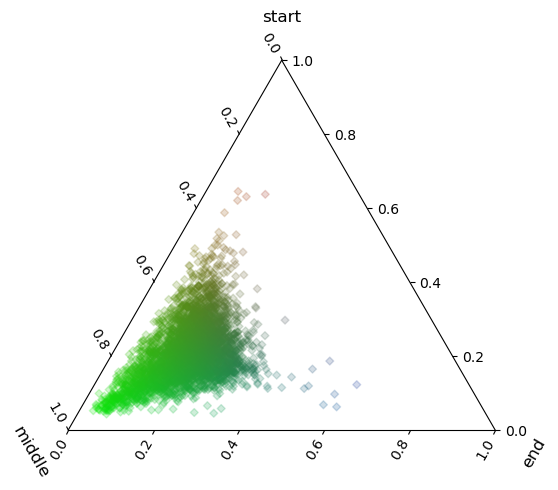

In [20]:
colors = ternary_color(df)
ax = df.loc[:, ['start', 'middle', 'end']].pyroplot.scatter(c=colors, alpha = 0.2)

plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/compositional_approach/first_10_middle_80_last_10_color_by_position.png')
plt.show()

In [40]:
df

,start,middle,end
0,0.257143,0.689286,0.053571
1,0.300613,0.576687,0.122699
2,0.203125,0.625000,0.171875
3,0.337349,0.554217,0.108434
4,0.210526,0.677193,0.112281
...,...,...,...
4084,0.214286,0.642857,0.142857
4085,0.206897,0.586207,0.206897
4086,0.210526,0.578947,0.210526
4087,0.074866,0.812834,0.112299


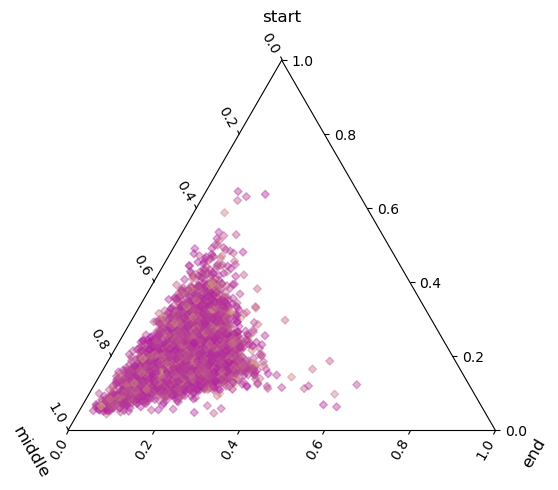

In [57]:
fig, axs = plt.subplots()

ax = df.loc[:, ['start', 'middle', 'end']].pyroplot.scatter(ax= axs, c=results_10['magnitude'], cmap = cmc.buda, alpha = 0.4)
#plt.colorbar(ax=ax)

#fig.colorbar(ax.collections[0], ax=ax, orientation='vertical', label='Magnitude', cmap=cmc.buda)
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/compositional_approach/first_10_middle_80_last_10_color_by_magntiude.png')
plt.show()
plt.close()

In [41]:
ax = df.loc[:, ['start', 'middle', 'end']].pyroplot.scatter(ax= ax, c=results_10['magnitude'], cmap = cmc.buda, alpha = 0.2)
#plt.colorbar(ax=ax)

#ax.figure.colorbar(ax.collections[0])
#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/compositional_approach/first_10_middle_80_last_10_color_by_position.png')
plt.show()

In [22]:
df2 = pd.DataFrame(columns = ['start', 'middle', 'end'])

df2['10_20'] = (results_db['20']-results_db['10'])/(results_db['90'] - results_db['10'])
df2['20_80'] = (results_db['80'] - results_db['20'])/(results_db['90'] - results_db['10'])
df2['80_90'] = (results_db['90'] - results_db['80'])/(results_db['90'] - results_db['10'])

/home/earthquakes1/software/Ubuntu/anaconda3/envs/rlc5/lib/python3.10/site-packages/pyrolite/comp/codata.py:43: UserWarning: Non-positive entries found. Closure operation assumes all positive entries.
  warnings.warn(


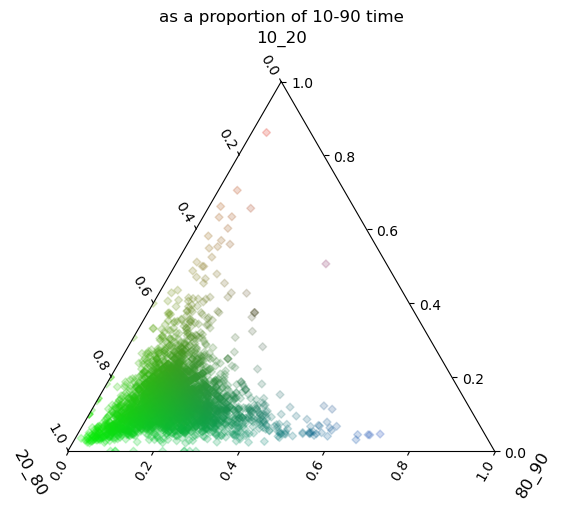

In [26]:
colors = ternary_color(df2.loc[:, ['10_20', '20_80', '80_90']])
ax = df2.loc[:, ['10_20', '20_80', '80_90']].pyroplot.scatter(c=colors, alpha = 0.2)

plt.title('as a proportion of 10-90 time')
plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/compositional_approach/second_10_middle_60_penultimate_10_as_prop_of_10_90_time_color_by_position.png')
plt.show()

In [24]:
df

,start,middle,end
0,0.257143,0.689286,0.053571
1,0.300613,0.576687,0.122699
2,0.203125,0.625000,0.171875
3,0.337349,0.554217,0.108434
4,0.210526,0.677193,0.112281
...,...,...,...
4084,0.214286,0.642857,0.142857
4085,0.206897,0.586207,0.206897
4086,0.210526,0.578947,0.210526
4087,0.074866,0.812834,0.112299


In [25]:
df2

,start,middle,end,10_20,20_80,80_90
0,NaN,NaN,NaN,0.264249,0.694301,0.041451
1,NaN,NaN,NaN,0.191489,0.680851,0.127660
2,NaN,NaN,NaN,0.125000,0.675000,0.200000
3,NaN,NaN,NaN,0.239130,0.673913,0.086957
4,NaN,NaN,NaN,0.113990,0.787565,0.098446
...,...,...,...,...,...,...
4084,NaN,NaN,NaN,0.466667,0.444444,0.088889
4085,NaN,NaN,NaN,0.176471,0.588235,0.235294
4086,NaN,NaN,NaN,0.151515,0.696970,0.151515
4087,NaN,NaN,NaN,0.059211,0.506579,0.434211
